# Deep Neural Nets Essentials

In this session we will deepen our focus on understanding various aspects of Deep Neural Nets

In [1]:
!nvidia-smi

Sat Feb 13 03:04:02 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import Dependencies

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn
import tensorflow as tf

In [3]:
print(tf.__version__)

2.4.1


In [4]:
print(sklearn.__version__)

0.22.2.post1


# 1. Building a DNN based Image Classifier

We will keep things simple here with regard to the key objective. We will build a simple apparel classifier by training models on the very famous [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset based on Zalando’s article images — consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. The idea is to classify these images into an apparel category amongst 10 categories on which we will be training our models on.

Here's an example how the data looks (each class takes three-rows):

<table>
  <tr><td>
    <img src="https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/doc/img/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Fashion MNIST is intended as a drop-in replacement for the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset—often used as the "Hello, World" of machine learning programs for computer vision. You can access the Fashion MNIST directly from TensorFlow.

__Note:__ Although these are really images, they are loaded as NumPy arrays and not binary image objects.

## 1.1: Understanding the data

In [5]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

X_train.shape, X_test.shape

4423680/4422102 [==============================] - 0s 0us/step


((60000, 28, 28), (10000, 28, 28))

We scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255 (NNs like normalized inputs).

In [6]:
X_train = X_train / 255.
X_test = X_test / 255.

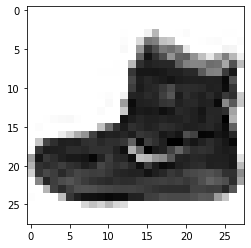

In [7]:
plt.imshow(X_train[0], cmap="binary");

The labels are the class IDs (represented as uint8), from 0 to 9:

In [8]:
y_train

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

Here are the corresponding class names:

In [9]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

So the first image in the training set is a Ankle Boot:

In [10]:
class_names[y_train[0]]

'Ankle boot'

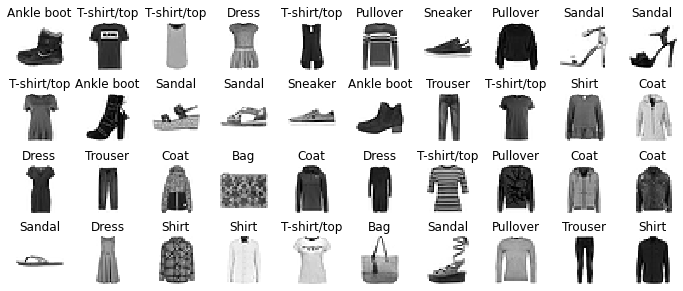

In [11]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5);

In [12]:
np.random.seed(42)
tf.random.set_seed(42)

In [13]:
28*28

784

## 1.2: Building a 2-layer DNN

Build a `Sequential` model (`tf.keras.models.Sequential`) and add four layers to it:
  * a `Flatten` layer (`tf.keras.layers.Flatten`) to convert each 28x28 image to a single row of 784 pixel values. Since it is the first layer in your model, you should specify the `input_shape` argument, leaving out the batch size: `[28, 28]`.
  * a `Dense` layer  (`tf.keras.layers.Dense`) with 300 neurons (aka units), and the `"relu"` activation function.
  * Another `Dense` layer with 100 neurons, also with the `"relu"` activation function.
  * A final `Dense` layer with 10 neurons (one per class), and with the `"softmax"` activation function to ensure that the sum of all the estimated class probabilities for each image is equal to 1.

In [14]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(10, activation="softmax")
                                    
])

After a model is created, you must call its `compile()` method to specify the `loss` function and the `optimizer` to use. In this case, you want to use the `"sparse_categorical_crossentropy"` loss, and the `keras.optimizers.SGD(lr=1e-3)` optimizer (stochastic gradient descent with learning rate of 1e-3). In this case you should specify `metrics=["accuracy"]`.

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=tf.keras.optimizers.SGD(1e-3),
              metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


## 1.3: Train & Test

Now your model is ready to be trained. Call its `fit()` method, passing it the input features (`X_train`) and the target classes (`y_train`). Set `epochs=10` (or else it will just run for a single epoch). You can also (optionally) pass 10% validation data by setting `validation_split=0.1`. If you do, Keras will compute the loss and the additional metrics (the accuracy in this case) on the validation set at the end of each epoch. If the performance on the training set is much better than on the validation set, your model is probably overfitting the training set (or there is a bug, such as a mismatch between the training set and the validation set).
**Note**: the `fit()` method will return a `History` object containing training stats. Make sure to preserve it (`history = model.fit(...)`).

In [ ]:
history = model.fit(X_train, y_train, 
                    epochs=20,
                    batch_size=32,
                    validation_split=0.1)

Epoch 1/20
1688/1688 [==============================] - 4s 2ms/step - loss: 1.5028 - accuracy: 0.5739 - val_loss: 1.0122 - val_accuracy: 0.7038
Epoch 2/20
1688/1688 [==============================] - 3s 2ms/step - loss: 0.8731 - accuracy: 0.7313 - val_loss: 0.7603 - val_accuracy: 0.7532
Epoch 3/20
1688/1688 [==============================] - 3s 2ms/step - loss: 0.7203 - accuracy: 0.7667 - val_loss: 0.6677 - val_accuracy: 0.7747
Epoch 4/20
1688/1688 [==============================] - 3s 2ms/step - loss: 0.6482 - accuracy: 0.7883 - val_loss: 0.6158 - val_accuracy: 0.7895
Epoch 5/20
1688/1688 [==============================] - 4s 2ms/step - loss: 0.6018 - accuracy: 0.8038 - val_loss: 0.5773 - val_accuracy: 0.8050
Epoch 6/20
1688/1688 [==============================] - 3s 2ms/step - loss: 0.5688 - accuracy: 0.8135 - val_loss: 0.5563 - val_accuracy: 0.8138
Epoch 7/20
1688/1688 [==============================] - 3s 2ms/step - loss: 0.5445 - accuracy: 0.8203 - val_loss: 0.5312 - val_accuracy:

Try running `pd.DataFrame(history.history).plot()` to plot the learning curves.

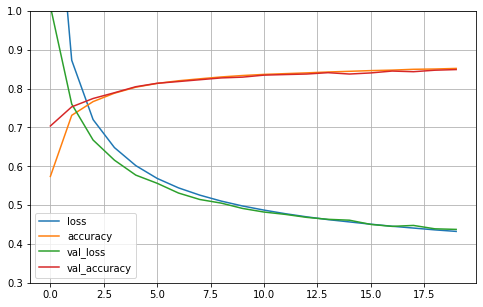

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.3, 1);

Call the model's `predict()` method to estimate the probability of each class for each instance

In [ ]:
y_pred = model.predict(X_test)
y_pred

array([[2.9123144e-05, 5.6710069e-06, 3.9882616e-05, ..., 2.1425611e-01,
        5.3555961e-03, 6.3845092e-01],
       [4.6123072e-04, 1.9474322e-05, 7.7543676e-01, ..., 1.2149670e-10,
        4.4851447e-05, 4.5031276e-09],
       [2.1345770e-05, 9.9986351e-01, 4.3233595e-06, ..., 8.8093415e-11,
        8.9394973e-07, 5.7581708e-09],
       ...,
       [7.6113254e-02, 1.6507634e-04, 2.3978287e-03, ..., 3.3976123e-04,
        7.2901016e-01, 1.4659639e-04],
       [1.2318377e-04, 9.9756974e-01, 2.4066707e-05, ..., 2.7917453e-08,
        9.3446106e-06, 3.1744657e-06],
       [5.4539222e-04, 1.8302802e-04, 9.8623044e-04, ..., 1.5533124e-01,
        2.5186859e-02, 2.4260342e-02]], dtype=float32)

In [ ]:
y_pred.shape

(10000, 10)

Often, you may only be interested in the most likely class. Use `np.argmax()` to get the class ID of the most likely class for each instance. **Tip**: you want to set `axis=1`.

In [ ]:
y_pred = y_pred.argmax(axis=1)
y_pred

array([9, 2, 1, ..., 8, 1, 5])

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred,
      target_names=class_names))

              precision    recall  f1-score   support

 T-shirt/top       0.80      0.81      0.80      1000
     Trouser       0.98      0.95      0.97      1000
    Pullover       0.79      0.66      0.72      1000
       Dress       0.83      0.87      0.85      1000
        Coat       0.73      0.77      0.75      1000
      Sandal       0.94      0.91      0.92      1000
       Shirt       0.58      0.61      0.59      1000
     Sneaker       0.90      0.91      0.90      1000
         Bag       0.93      0.94      0.93      1000
  Ankle boot       0.92      0.94      0.93      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



# 2. Other Activation Functions

## 2.1: Vanishing/Exploding Gradients Problem

When training a deep neural network with differentiation i.e gradient computations via backpropagation, we find the partial derivatives by traversing the network from the the output layer to the initial layer. 

Using the chain rule, layers that are deeper into the network go through a large number of matrix multiplications in order to compute derivatives.

n a network of n hidden layers, n derivatives will be multiplied together. If the derivatives are large then the gradient will increase exponentially as we propagate down the model until they eventually explode, and this is what we call the problem of exploding gradient. 

Alternatively, if the derivatives are small then the gradient will decrease exponentially as we propagate through the model until it eventually vanishes, and this is the vanishing gradient problem.

[Source](https://towardsdatascience.com/the-vanishing-exploding-gradient-problem-in-deep-neural-networks-191358470c11)


Activation functions whose gradients contract as they saturate
are typically referred to as saturating nonlinearities; in that
sense, rectified linear units (ReLU) (Nair and Hinton 2010)
are non-saturating and thus help reduce vanishing gradients
in deep feed-forward networks

[Source](https://arxiv.org/pdf/1902.06704.pdf)

In [17]:
def logit(z):
    return 1 / (1 + np.exp(-z))

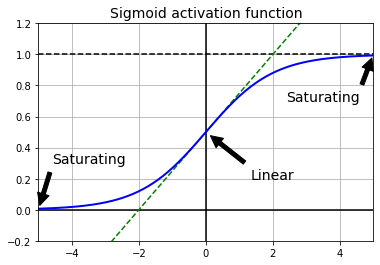

In [18]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2]);

## 2.2: Nonsaturating Activation Functions

### ReLu

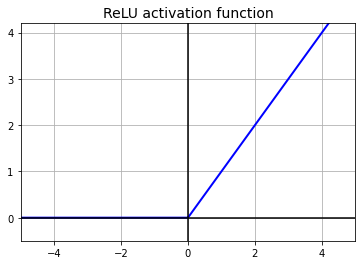

In [21]:
plt.plot(z, tf.nn.relu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.title("ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2]);

### Leaky ReLu

Proposed in 2013 as an activation function that introduces a small negative slope to the ReLU function to prevent dead neurons

In [ ]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

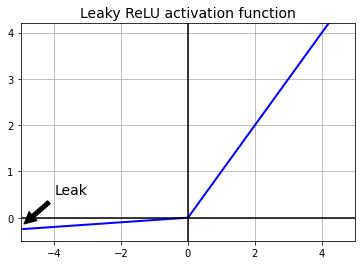

In [ ]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2]);

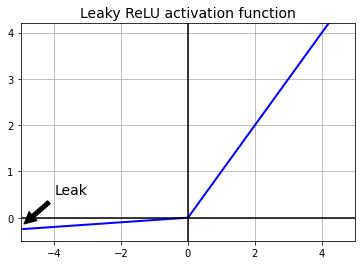

In [ ]:
plt.plot(z, tf.nn.leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2]);

In [ ]:
[m for m in dir(tf.keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'swish',
 'tanh']

### Training with LeakyReLu

In [ ]:
leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.1)
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation=leaky_relu),
    tf.keras.layers.Dense(100, activation=leaky_relu),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=tf.keras.optimizers.SGD(1e-3),
              metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 300)               235500    
_________________________________________________________________
dense_4 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, 
                    epochs=20,
                    batch_size=32,
                    validation_split=0.1)

Epoch 1/20
1688/1688 [==============================] - 4s 2ms/step - loss: 1.3688 - accuracy: 0.6149 - val_loss: 0.9200 - val_accuracy: 0.7220
Epoch 2/20
1688/1688 [==============================] - 4s 2ms/step - loss: 0.8234 - accuracy: 0.7391 - val_loss: 0.7263 - val_accuracy: 0.7640
Epoch 3/20
1688/1688 [==============================] - 3s 2ms/step - loss: 0.6984 - accuracy: 0.7737 - val_loss: 0.6450 - val_accuracy: 0.7857
Epoch 4/20
1688/1688 [==============================] - 4s 2ms/step - loss: 0.6349 - accuracy: 0.7924 - val_loss: 0.5999 - val_accuracy: 0.7935
Epoch 5/20
1688/1688 [==============================] - 4s 2ms/step - loss: 0.5936 - accuracy: 0.8047 - val_loss: 0.5649 - val_accuracy: 0.8077
Epoch 6/20
1688/1688 [==============================] - 4s 2ms/step - loss: 0.5640 - accuracy: 0.8132 - val_loss: 0.5470 - val_accuracy: 0.8123
Epoch 7/20
1688/1688 [==============================] - 3s 2ms/step - loss: 0.5419 - accuracy: 0.8184 - val_loss: 0.5231 - val_accuracy:

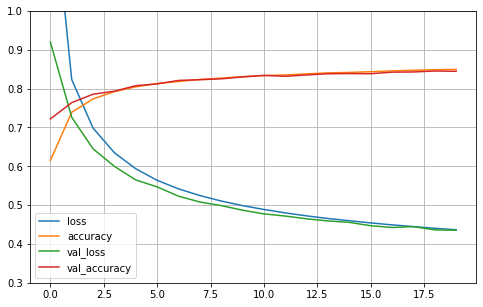

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.3, 1);

In [ ]:
y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis=1)
print(classification_report(y_test, y_pred,
      target_names=class_names))

              precision    recall  f1-score   support

 T-shirt/top       0.79      0.82      0.80      1000
     Trouser       0.97      0.95      0.96      1000
    Pullover       0.78      0.64      0.71      1000
       Dress       0.83      0.85      0.84      1000
        Coat       0.71      0.76      0.74      1000
      Sandal       0.94      0.92      0.93      1000
       Shirt       0.57      0.60      0.59      1000
     Sneaker       0.90      0.91      0.91      1000
         Bag       0.94      0.94      0.94      1000
  Ankle boot       0.92      0.94      0.93      1000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



### ELU

Very Similar to leaky ReLU, ELU has a small slope for negative values. Instead of a straight line, it uses a log curve

In [ ]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

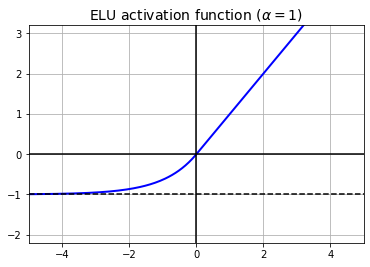

In [ ]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2]);

### SELU

This activation function was proposed in this [excellent paper](https://arxiv.org/pdf/1706.02515.pdf) by Günter Klambauer, Thomas Unterthiner and Andreas Mayr, published in June 2017. 

During training, a neural network composed exclusively of a stack of dense layers using the SELU activation function and LeCun initialization will self-normalize: 

 - the output of each layer will tend to preserve the same mean and variance during training, which solves the vanishing/exploding gradients problem
 - As a result, this activation function outperforms the other activation functions very significantly for such neural nets, so you should really try it out. 
 
Unfortunately, the self-normalizing property of the SELU activation function is easily broken: you cannot use ℓ<sub>1</sub> or ℓ<sub>2</sub> regularization, regular dropout, max-norm, skip connections or other non-sequential topologies (so recurrent neural networks won't self-normalize). However, in practice it works quite well with sequential CNNs. 

If you break self-normalization, SELU will not necessarily outperform other activation functions.

Source: https://www.google.co.in/books/edition/Hands_On_Machine_Learning_with_Scikit_Le/bRpYDgAAQBAJ

In [ ]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [ ]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

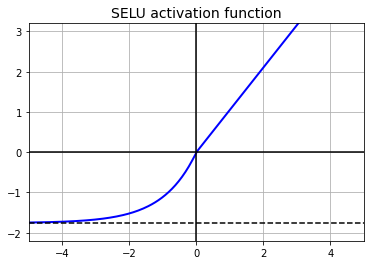

In [ ]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2]);

By default, the SELU hyperparameters (`scale` and `alpha`) are tuned in such a way that the mean output of each neuron remains close to 0, and the standard deviation remains close to 1 (assuming the inputs are standardized with mean 0 and standard deviation 1 too). Using this activation function, even a 1,000 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:

In [ ]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # standardized inputs
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun initialization
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


### Training with SELU

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, 
                          activation='selu', 
                          kernel_initializer='lecun_normal'),
    tf.keras.layers.Dense(100, 
                          activation='selu', 
                          kernel_initializer='lecun_normal'),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=tf.keras.optimizers.SGD(1e-3),
              metrics=["accuracy"])

Now let's train it. Do not forget to scale the inputs to mean 0 and standard deviation 1:

In [ ]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [ ]:
history = model.fit(X_train_scaled, y_train, epochs=20,
                    validation_split=0.1)

Epoch 1/20
1688/1688 [==============================] - 4s 2ms/step - loss: 0.6931 - accuracy: 0.7608 - val_loss: 0.5174 - val_accuracy: 0.8122
Epoch 2/20
1688/1688 [==============================] - 4s 2ms/step - loss: 0.5005 - accuracy: 0.8251 - val_loss: 0.4639 - val_accuracy: 0.8295
Epoch 3/20
1688/1688 [==============================] - 3s 2ms/step - loss: 0.4590 - accuracy: 0.8402 - val_loss: 0.4405 - val_accuracy: 0.8380
Epoch 4/20
1688/1688 [==============================] - 3s 2ms/step - loss: 0.4355 - accuracy: 0.8478 - val_loss: 0.4244 - val_accuracy: 0.8455
Epoch 5/20
1688/1688 [==============================] - 4s 2ms/step - loss: 0.4190 - accuracy: 0.8536 - val_loss: 0.4144 - val_accuracy: 0.8515
Epoch 6/20
1688/1688 [==============================] - 4s 2ms/step - loss: 0.4063 - accuracy: 0.8584 - val_loss: 0.4076 - val_accuracy: 0.8530
Epoch 7/20
1688/1688 [==============================] - 3s 2ms/step - loss: 0.3958 - accuracy: 0.8625 - val_loss: 0.3982 - val_accuracy:

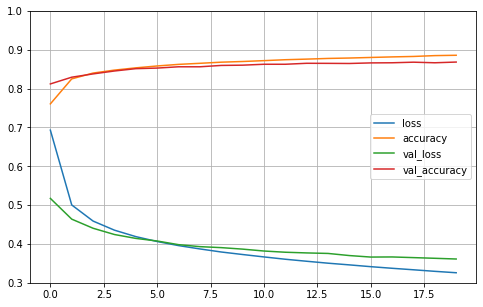

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.3, 1);

In [ ]:
y_pred = model.predict(X_test_scaled)
y_pred = y_pred.argmax(axis=1)
print(classification_report(y_test, y_pred,
      target_names=class_names))

              precision    recall  f1-score   support

 T-shirt/top       0.81      0.82      0.82      1000
     Trouser       0.98      0.96      0.97      1000
    Pullover       0.78      0.76      0.77      1000
       Dress       0.83      0.89      0.86      1000
        Coat       0.78      0.77      0.78      1000
      Sandal       0.95      0.92      0.94      1000
       Shirt       0.67      0.64      0.65      1000
     Sneaker       0.91      0.94      0.93      1000
         Bag       0.95      0.96      0.95      1000
  Ankle boot       0.95      0.95      0.95      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



# 3. Batch Normalization

Batch normalization is a technique for training deep neural networks that standardizes the inputs for each mini-batch before going into a layer. This has the effect of stabilizing the learning process and preventing overfitting.

- fixed distributions of inputs  would remove the ill effects of the internal covariate shift (change in the distributions of neurons when training) [https://arxiv.org/abs/1502.03167]

- Batch normalization acts to standardize only the mean and variance of each unit in order to stabilize learning [https://amzn.to/2NJW3gE]

## 3.1 Build Model with Batchnorm

In [ ]:
model = tf.keras.models.Sequential([
                                    
    tf.keras.layers.Flatten(input_shape=[28, 28]),

    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(300, 
                          activation='relu'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(100, 
                          activation='relu'),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Dense(10, activation="softmax")
])

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=tf.keras.optimizers.SGD(1e-3),
              metrics=["accuracy"])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense_9 (Dense)              (None, 300)               235500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_10 (Dense)             (None, 100)               30100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_11 (Dense)             (None, 10)               

## Train & Test with Batchnorm

In [ ]:
history = model.fit(X_train, y_train, epochs=20,
                    validation_split=0.1)

Epoch 1/20
1688/1688 [==============================] - 6s 4ms/step - loss: 0.8514 - accuracy: 0.7147 - val_loss: 0.5683 - val_accuracy: 0.8027
Epoch 2/20
1688/1688 [==============================] - 6s 3ms/step - loss: 0.5785 - accuracy: 0.7996 - val_loss: 0.4920 - val_accuracy: 0.8270
Epoch 3/20
1688/1688 [==============================] - 6s 3ms/step - loss: 0.5180 - accuracy: 0.8195 - val_loss: 0.4556 - val_accuracy: 0.8390
Epoch 4/20
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4842 - accuracy: 0.8311 - val_loss: 0.4310 - val_accuracy: 0.8473
Epoch 5/20
1688/1688 [==============================] - 6s 3ms/step - loss: 0.4597 - accuracy: 0.8383 - val_loss: 0.4159 - val_accuracy: 0.8520
Epoch 6/20
1688/1688 [==============================] - 6s 3ms/step - loss: 0.4434 - accuracy: 0.8438 - val_loss: 0.4031 - val_accuracy: 0.8567
Epoch 7/20
1688/1688 [==============================] - 6s 3ms/step - loss: 0.4271 - accuracy: 0.8499 - val_loss: 0.3920 - val_accuracy:

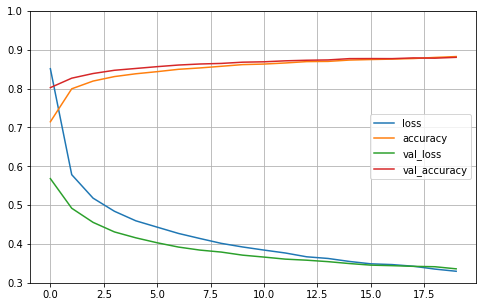

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.3, 1);

In [ ]:
y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis=1)
print(classification_report(y_test, y_pred,
      target_names=class_names))

              precision    recall  f1-score   support

 T-shirt/top       0.82      0.83      0.83      1000
     Trouser       0.98      0.96      0.97      1000
    Pullover       0.79      0.77      0.78      1000
       Dress       0.86      0.89      0.87      1000
        Coat       0.78      0.80      0.79      1000
      Sandal       0.94      0.94      0.94      1000
       Shirt       0.69      0.65      0.67      1000
     Sneaker       0.92      0.94      0.93      1000
         Bag       0.95      0.96      0.96      1000
  Ankle boot       0.94      0.94      0.94      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



## Changing the position of Batchnorm

Sometimes applying BN before the activation function works better (there's a debate on this topic). Moreover, the layer before a `BatchNormalization` layer does not need to have bias terms, since the `BatchNormalization` layer already includes it, hence it would be a waste of parameters, so you can set `use_bias=False` when creating those layers

Source: https://www.google.co.in/books/edition/Hands_On_Machine_Learning_with_Scikit_Le/bRpYDgAAQBAJ

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(300, use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),

    tf.keras.layers.Dense(100, use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),

    tf.keras.layers.Dense(10, activation="softmax")
])

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=tf.keras.optimizers.SGD(1e-3),
              metrics=["accuracy"])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 784)               3136      
_________________________________________________________________
dense_12 (Dense)             (None, 300)               235200    
_________________________________________________________________
batch_normalization_4 (Batch (None, 300)               1200      
_________________________________________________________________
activation (Activation)      (None, 300)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 100)               30000     
_________________________________________________________________
batch_normalization_5 (Batch (None, 100)              

In [ ]:
history = model.fit(X_train, y_train, epochs=20,
                    validation_split=0.1, batch_size=32)

Epoch 1/20
1688/1688 [==============================] - 6s 3ms/step - loss: 1.0356 - accuracy: 0.6697 - val_loss: 0.6713 - val_accuracy: 0.7822
Epoch 2/20
1688/1688 [==============================] - 6s 3ms/step - loss: 0.6719 - accuracy: 0.7804 - val_loss: 0.5560 - val_accuracy: 0.8118
Epoch 3/20
1688/1688 [==============================] - 5s 3ms/step - loss: 0.5891 - accuracy: 0.8045 - val_loss: 0.5056 - val_accuracy: 0.8243
Epoch 4/20
1688/1688 [==============================] - 6s 3ms/step - loss: 0.5418 - accuracy: 0.8173 - val_loss: 0.4735 - val_accuracy: 0.8337
Epoch 5/20
1688/1688 [==============================] - 6s 3ms/step - loss: 0.5118 - accuracy: 0.8240 - val_loss: 0.4513 - val_accuracy: 0.8415
Epoch 6/20
1688/1688 [==============================] - 6s 3ms/step - loss: 0.4900 - accuracy: 0.8311 - val_loss: 0.4353 - val_accuracy: 0.8468
Epoch 7/20
1688/1688 [==============================] - 6s 3ms/step - loss: 0.4720 - accuracy: 0.8366 - val_loss: 0.4223 - val_accuracy:

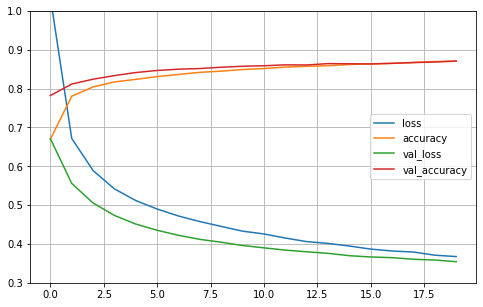

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.3, 1);

In [ ]:
y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis=1)
print(classification_report(y_test, y_pred,
      target_names=class_names))

              precision    recall  f1-score   support

 T-shirt/top       0.82      0.83      0.83      1000
     Trouser       0.99      0.96      0.97      1000
    Pullover       0.78      0.77      0.78      1000
       Dress       0.84      0.90      0.87      1000
        Coat       0.78      0.79      0.79      1000
      Sandal       0.94      0.94      0.94      1000
       Shirt       0.69      0.64      0.66      1000
     Sneaker       0.92      0.94      0.93      1000
         Bag       0.95      0.96      0.96      1000
  Ankle boot       0.94      0.94      0.94      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



# 4. Optimizers

Optmizers help in reducing the loss in your network via gradient descent following optimized strategies to get a better minima.

## Gradient Descent

Gradient descent is a first-order optimization algorithm which is dependent on the first order derivative of a loss function. It calculates that which way the weights should be altered so that the function can reach a minima.

GD: θ=θ−α⋅∇J(θ)

Need to compute gradient over the whole dataset which can be inefficient


## Stochastic Gradient Descent

It’s a variant of Gradient Descent. It tries to update the model’s parameters more frequently. In this, the model parameters are altered after computation of loss on each training example. So, if the dataset contains 1000 rows SGD will update the model parameters 1000 times in one cycle of dataset instead of one time as in Gradient Descent.

θ=θ−α⋅∇J(θ;x(i);y(i)) , where {x(i) ,y(i)} are the training examples.

Can lead to high variance

## Mini-Batch Gradient Descent

It is an improvement on both SGD and standard gradient descent. It updates the model parameters after every batch of data. So, the dataset is divided into various batches and after every batch, the parameters are updated.

θ=θ−α⋅∇J(θ; B(i)), where {B(i)} are the batches of training examples.

## Momentum

Momentum was invented for reducing high variance in SGD and softens the convergence. It accelerates the convergence towards the relevant direction and reduces the fluctuation to the irrelevant direction. One more hyperparameter is used in this method known as momentum symbolized by ‘γ’.

V(t)=γV(t−1)+α.∇J(θ)

V is the exponentially weighted average of past gradients

Now, the weights are updated by θ=θ−V(t).
The momentum term γ is usually set to 0.9 or a similar value.

## Adaptive Moment Estimation

Adam (Adaptive Moment Estimation) works with momentums of first and second order. The intuition behind the Adam is that we don’t want to roll so fast just because we can jump over the minimum, we want to decrease the velocity a little bit for a careful search.

M(t) and V(t) are values of the first moment which is the Mean and the second moment which is the uncentered variance of the gradients respectively.

![](https://i.imgur.com/8qZUgZJ.png)

Final paramter updates occur as:

![](https://i.imgur.com/RmA9ghf.png)

η is a learning rate which is modified for given parameter θ(i) at a given time based on previous gradients calculated for given parameter θ(i).

Usual values for β1 is 0.9 , 0.999 for β2, and (10 x exp(-8)) for ‘ϵ’.

[Source](https://towardsdatascience.com/optimizers-for-training-neural-network-59450d71caf6)


## 4.1: Train DNN with Adam

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(300, use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(100, use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    
    tf.keras.layers.Dense(10, activation="softmax")
])

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=tf.keras.optimizers.Adam(lr=1e-3, 
                                                 beta_1=0.9, 
                                                 beta_2=0.999),
              metrics=["accuracy"])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 784)               3136      
_________________________________________________________________
dense_15 (Dense)             (None, 300)               235200    
_________________________________________________________________
batch_normalization_7 (Batch (None, 300)               1200      
_________________________________________________________________
activation_2 (Activation)    (None, 300)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 100)               30000     
_________________________________________________________________
batch_normalization_8 (Batch (None, 100)              

In [ ]:
history = model.fit(X_train, y_train, epochs=20,
                    validation_split=0.1)

Epoch 1/20
1688/1688 [==============================] - 6s 4ms/step - loss: 0.4620 - accuracy: 0.8336 - val_loss: 0.3520 - val_accuracy: 0.8715
Epoch 2/20
1688/1688 [==============================] - 6s 4ms/step - loss: 0.3569 - accuracy: 0.8679 - val_loss: 0.3220 - val_accuracy: 0.8820
Epoch 3/20
1688/1688 [==============================] - 6s 4ms/step - loss: 0.3192 - accuracy: 0.8832 - val_loss: 0.3124 - val_accuracy: 0.8848
Epoch 4/20
1688/1688 [==============================] - 6s 4ms/step - loss: 0.2930 - accuracy: 0.8904 - val_loss: 0.3089 - val_accuracy: 0.8880
Epoch 5/20
1688/1688 [==============================] - 7s 4ms/step - loss: 0.2726 - accuracy: 0.8974 - val_loss: 0.3152 - val_accuracy: 0.8878
Epoch 6/20
1688/1688 [==============================] - 7s 4ms/step - loss: 0.2540 - accuracy: 0.9041 - val_loss: 0.3133 - val_accuracy: 0.8850
Epoch 7/20
1688/1688 [==============================] - 6s 3ms/step - loss: 0.2393 - accuracy: 0.9109 - val_loss: 0.2908 - val_accuracy:

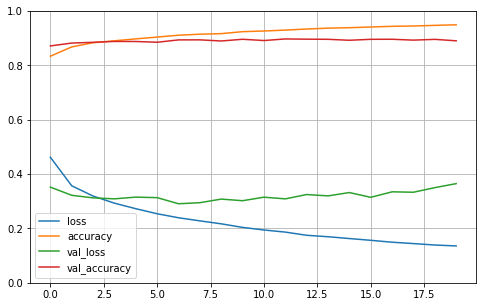

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1);

In [ ]:
y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis=1)
print(classification_report(y_test, y_pred,
      target_names=class_names))

              precision    recall  f1-score   support

 T-shirt/top       0.80      0.87      0.83      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.82      0.80      0.81      1000
       Dress       0.93      0.86      0.89      1000
        Coat       0.82      0.81      0.82      1000
      Sandal       0.95      0.98      0.97      1000
       Shirt       0.69      0.72      0.71      1000
     Sneaker       0.95      0.96      0.96      1000
         Bag       0.98      0.96      0.97      1000
  Ankle boot       0.97      0.94      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



# 5. Dynamic Learning Rate Schedules

Why keep the learning rate constant when changing it over the training process can yield better results often?

## 5.1 Training with exponential decay schedule

```
lr = lr0 * 0.1**(epoch / s)
```

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(300, use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(100, use_bias=False),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=tf.keras.optimizers.Adam(lr=1e-3, 
                                                 beta_1=0.9, 
                                                 beta_2=0.999),
              metrics=["accuracy"])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 784)               3136      
_________________________________________________________________
dense_18 (Dense)             (None, 300)               235200    
_________________________________________________________________
batch_normalization_10 (Batc (None, 300)               1200      
_________________________________________________________________
activation_4 (Activation)    (None, 300)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 100)               30000     
_________________________________________________________________
activation_5 (Activation)    (None, 100)              

In [ ]:
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn,
                                                        verbose=1)
history = model.fit(X_train, y_train, epochs=20,
                    validation_split=0.1,
                    callbacks=[lr_scheduler])


Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
Epoch 1/20
1688/1688 [==============================] - 6s 4ms/step - loss: 0.5103 - accuracy: 0.8161 - val_loss: 0.4049 - val_accuracy: 0.8513

Epoch 00002: LearningRateScheduler reducing learning rate to 0.008912509381337455.
Epoch 2/20
1688/1688 [==============================] - 6s 3ms/step - loss: 0.3948 - accuracy: 0.8548 - val_loss: 0.3580 - val_accuracy: 0.8688

Epoch 00003: LearningRateScheduler reducing learning rate to 0.007943282347242816.
Epoch 3/20
1688/1688 [==============================] - 6s 4ms/step - loss: 0.3520 - accuracy: 0.8719 - val_loss: 0.3339 - val_accuracy: 0.8767

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0070794578438413795.
Epoch 4/20
1688/1688 [==============================] - 7s 4ms/step - loss: 0.3230 - accuracy: 0.8806 - val_loss: 0.3439 - val_accuracy: 0.8790

Epoch 00005: LearningRateScheduler reducing learning rate to 0.006309573444801933.
Epoch 5/20
1688/168

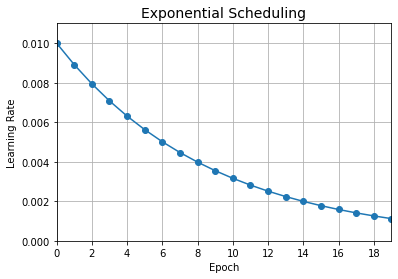

In [ ]:
from matplotlib.ticker import MaxNLocator

plt.figure().gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.plot(history.epoch, history.history["lr"], "o-")
n_epochs=20
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True);

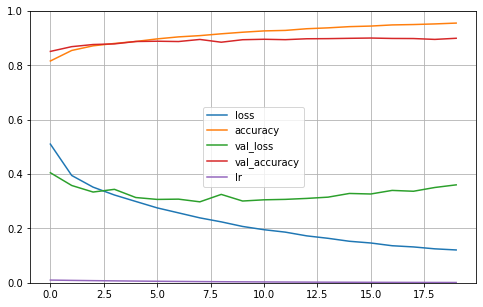

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1);

In [ ]:
y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis=1)
print(classification_report(y_test, y_pred,
      target_names=class_names))

              precision    recall  f1-score   support

 T-shirt/top       0.84      0.84      0.84      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.83      0.80      0.82      1000
       Dress       0.91      0.89      0.90      1000
        Coat       0.82      0.83      0.83      1000
      Sandal       0.97      0.97      0.97      1000
       Shirt       0.70      0.73      0.71      1000
     Sneaker       0.93      0.97      0.95      1000
         Bag       0.98      0.96      0.97      1000
  Ankle boot       0.97      0.94      0.95      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



## 5.2 Training with Piecewise constant scheduling


In [ ]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn

In [ ]:
piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(300, use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(100, use_bias=False),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=tf.keras.optimizers.Adam(lr=1e-3, 
                                                 beta_1=0.9, 
                                                 beta_2=0.999),
              metrics=["accuracy"])

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(piecewise_constant_fn,
                                                        verbose=1)
history = model.fit(X_train, y_train, epochs=20,
                    validation_split=0.1,
                    callbacks=[lr_scheduler])


Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
Epoch 1/20
1688/1688 [==============================] - 6s 4ms/step - loss: 0.5128 - accuracy: 0.8155 - val_loss: 0.4115 - val_accuracy: 0.8550

Epoch 00002: LearningRateScheduler reducing learning rate to 0.01.
Epoch 2/20
1688/1688 [==============================] - 6s 3ms/step - loss: 0.4027 - accuracy: 0.8530 - val_loss: 0.3609 - val_accuracy: 0.8683

Epoch 00003: LearningRateScheduler reducing learning rate to 0.01.
Epoch 3/20
1688/1688 [==============================] - 6s 3ms/step - loss: 0.3653 - accuracy: 0.8674 - val_loss: 0.3619 - val_accuracy: 0.8725

Epoch 00004: LearningRateScheduler reducing learning rate to 0.01.
Epoch 4/20
1688/1688 [==============================] - 6s 4ms/step - loss: 0.3414 - accuracy: 0.8743 - val_loss: 0.3577 - val_accuracy: 0.8723

Epoch 00005: LearningRateScheduler reducing learning rate to 0.01.
Epoch 5/20
1688/1688 [==============================] - 6s 3ms/step - loss: 0.3231 -

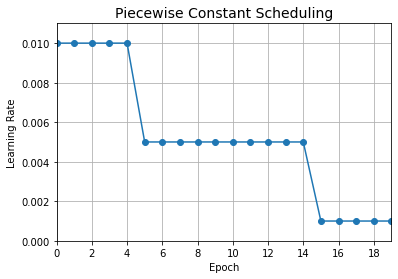

In [ ]:
plt.figure().gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.plot(history.epoch, [piecewise_constant_fn(epoch) for epoch in history.epoch], "o-")
n_epochs=20
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True);

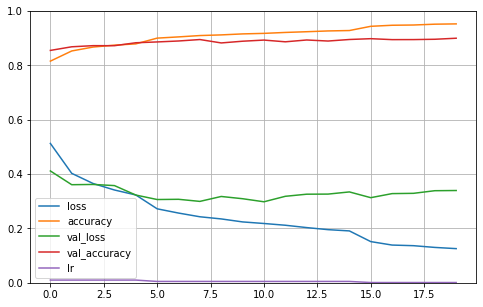

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1);

In [ ]:
y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis=1)
print(classification_report(y_test, y_pred,
      target_names=class_names))

              precision    recall  f1-score   support

 T-shirt/top       0.84      0.83      0.84      1000
     Trouser       0.99      0.98      0.98      1000
    Pullover       0.84      0.81      0.83      1000
       Dress       0.91      0.90      0.91      1000
        Coat       0.83      0.85      0.84      1000
      Sandal       0.98      0.97      0.97      1000
       Shirt       0.72      0.74      0.73      1000
     Sneaker       0.94      0.97      0.95      1000
         Bag       0.98      0.97      0.97      1000
  Ankle boot       0.97      0.94      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



# 6. Other Regularization Strategies

Other strategies to prevent overfitting

## 6.1 $\ell_1$ and $\ell_2$ regularization

In [ ]:
from functools import partial

RegularizedDense = partial(tf.keras.layers.Dense,
                           activation="elu",
                           kernel_initializer="glorot_uniform",
                           kernel_regularizer=tf.keras.regularizers.l2(0.001))

model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer="adam", metrics=["accuracy"])

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn,
                                                        verbose=1)
history = model.fit(X_train, y_train, epochs=20,
                    validation_split=0.1,
                    callbacks=[lr_scheduler])


Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
Epoch 1/20
1688/1688 [==============================] - 4s 3ms/step - loss: 1.0361 - accuracy: 0.7427 - val_loss: 0.8779 - val_accuracy: 0.7858

Epoch 00002: LearningRateScheduler reducing learning rate to 0.008912509381337455.
Epoch 2/20
1688/1688 [==============================] - 4s 2ms/step - loss: 0.8286 - accuracy: 0.7866 - val_loss: 0.7501 - val_accuracy: 0.8138

Epoch 00003: LearningRateScheduler reducing learning rate to 0.007943282347242816.
Epoch 3/20
1688/1688 [==============================] - 4s 2ms/step - loss: 0.7788 - accuracy: 0.7978 - val_loss: 0.8271 - val_accuracy: 0.7565

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0070794578438413795.
Epoch 4/20
1688/1688 [==============================] - 4s 2ms/step - loss: 0.7440 - accuracy: 0.8018 - val_loss: 0.7839 - val_accuracy: 0.7862

Epoch 00005: LearningRateScheduler reducing learning rate to 0.006309573444801933.
Epoch 5/20
1688/168

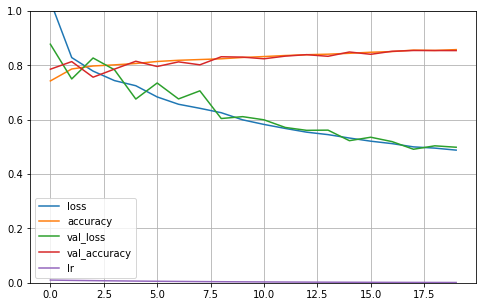

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1);

In [ ]:
y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis=1)
print(classification_report(y_test, y_pred,
      target_names=class_names))

              precision    recall  f1-score   support

 T-shirt/top       0.76      0.85      0.81      1000
     Trouser       0.98      0.94      0.96      1000
    Pullover       0.78      0.71      0.74      1000
       Dress       0.78      0.92      0.84      1000
        Coat       0.76      0.75      0.75      1000
      Sandal       0.97      0.88      0.92      1000
       Shirt       0.62      0.55      0.58      1000
     Sneaker       0.86      0.97      0.91      1000
         Bag       0.96      0.93      0.94      1000
  Ankle boot       0.96      0.91      0.94      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



## 6.2: Dropout

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(300, activation="elu", kernel_initializer="glorot_uniform"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation="elu", kernel_initializer="glorot_uniform"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer="adam", metrics=["accuracy"])

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn,
                                                        verbose=1)
history = model.fit(X_train, y_train, epochs=20,
                    validation_split=0.1,
                    callbacks=[lr_scheduler])


Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
Epoch 1/20
1688/1688 [==============================] - 4s 3ms/step - loss: 0.8610 - accuracy: 0.7043 - val_loss: 0.6167 - val_accuracy: 0.7830

Epoch 00002: LearningRateScheduler reducing learning rate to 0.008912509381337455.
Epoch 2/20
1688/1688 [==============================] - 4s 2ms/step - loss: 0.7543 - accuracy: 0.7453 - val_loss: 0.5290 - val_accuracy: 0.8085

Epoch 00003: LearningRateScheduler reducing learning rate to 0.007943282347242816.
Epoch 3/20
1688/1688 [==============================] - 4s 2ms/step - loss: 0.6671 - accuracy: 0.7685 - val_loss: 0.5249 - val_accuracy: 0.8060

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0070794578438413795.
Epoch 4/20
1688/1688 [==============================] - 4s 2ms/step - loss: 0.6351 - accuracy: 0.7816 - val_loss: 0.4758 - val_accuracy: 0.8340

Epoch 00005: LearningRateScheduler reducing learning rate to 0.006309573444801933.
Epoch 5/20
1688/168

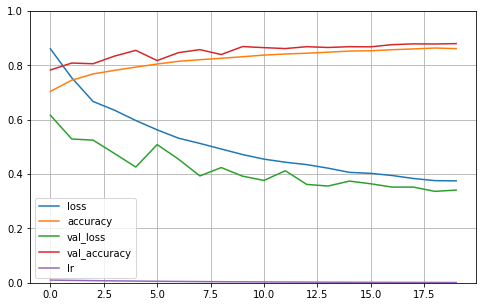

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1);

In [ ]:
y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis=1)
print(classification_report(y_test, y_pred,
      target_names=class_names))

              precision    recall  f1-score   support

 T-shirt/top       0.82      0.84      0.83      1000
     Trouser       0.99      0.96      0.98      1000
    Pullover       0.82      0.74      0.78      1000
       Dress       0.86      0.91      0.88      1000
        Coat       0.79      0.79      0.79      1000
      Sandal       0.99      0.94      0.97      1000
       Shirt       0.65      0.69      0.67      1000
     Sneaker       0.93      0.97      0.95      1000
         Bag       0.98      0.97      0.98      1000
  Ankle boot       0.95      0.96      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



# Convolutional Neural Networks - Building CNN Classifiers


The most popular deep learning models leveraged for computer vision problems are convolutional neural networks (CNNs)!

# Brief on CNNs

CNNs typically consist of multiple convolution and pooling layers which help the deep learning model in automatically extracting relevant features from visual data like images. Due to this multi-layered architecture, CNNs learn a robust hierarchy of features, which are spatial, rotation, and translation invariant.

![](https://miro.medium.com/max/1456/1*NKL76WYQwH5LuqyaQTjBNw.png)

The key operations in a CNN model are depicted in the figure above. Any image can be represented as a tensor of pixel values. The convolution layers help in extracting features from this image (forms feature maps). Shallower layers (closer to the input data) in the network learn very generic features like edges, corners and so on. Deeper layers in the network (closer to the output layer) learn very specific features pertaining to the input image. The following graphic helps summarize the key aspects of any CNN model.

![](https://miro.medium.com/max/1366/1*nCQeDMjKoTGst1RiCDo9Fw.png)

We will be building a CNN from scratch in this tutorial. 

In [22]:
X_train.shape

(60000, 28, 28)

## Reshaping Image Data for Modeling

We do need to reshape our data before we train our model. Here we will work on grayscale, 1-channel images (image pixel tensors)

In [25]:
# reshape for feeding into the model
train_images = X_train.reshape(X_train.shape[0], 28, 28, 1)
test_images = X_test.reshape(X_test.shape[0], 28, 28, 1)

print('\nTrain_images.shape: {}, of {}'.format(train_images.shape, train_images.dtype))
print('Test_images.shape: {}, of {}'.format(test_images.shape, test_images.dtype))


Train_images.shape: (60000, 28, 28, 1), of float64
Test_images.shape: (10000, 28, 28, 1), of float64


## Build CNN Model Architecture

We will now build our basic 2-layer CNN model architecture.

In [27]:
# define input shape
INPUT_SHAPE = (28, 28, 1)

# define sequential model
model = tf.keras.models.Sequential()
# define conv-pool layers - set 1
model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), 
                                activation='relu', padding='valid', input_shape=INPUT_SHAPE))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# define conv-pool layers - set 2
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), 
                                activation='relu', padding='valid'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# add flatten layer
model.add(tf.keras.layers.Flatten())

# add dense layers with some dropout
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.3))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.3))

# add output layer
model.add(tf.keras.layers.Dense(10, activation='softmax'))

# compile model
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# view model layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               205056    
_________________________________________________________________
dropout (Dropout)            (None, 256)              

## Model Training

Let’s train our model for 100 epochs and look at the performance. We do apply an early-stopping to stop the model training immediately once we don't see an improvement in validation-loss over the last 2 epochs using the `EarlyStopping` callback.

In [29]:
EPOCHS = 100
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, 
                                               restore_best_weights=True,
                                               verbose=1)

history = model.fit(train_images, y_train,
                    batch_size=32,
                    callbacks=[es_callback], 
                    validation_split=0.1, epochs=EPOCHS,
                    verbose=1)

Epoch 1/100
1688/1688 [==============================] - 8s 3ms/step - loss: 0.7408 - accuracy: 0.7275 - val_loss: 0.3754 - val_accuracy: 0.8615
Epoch 2/100
1688/1688 [==============================] - 4s 2ms/step - loss: 0.3688 - accuracy: 0.8666 - val_loss: 0.2996 - val_accuracy: 0.8898
Epoch 3/100
1688/1688 [==============================] - 4s 2ms/step - loss: 0.3073 - accuracy: 0.8859 - val_loss: 0.2806 - val_accuracy: 0.8928
Epoch 4/100
1688/1688 [==============================] - 4s 3ms/step - loss: 0.2740 - accuracy: 0.8984 - val_loss: 0.2670 - val_accuracy: 0.9023
Epoch 5/100
1688/1688 [==============================] - 4s 2ms/step - loss: 0.2548 - accuracy: 0.9072 - val_loss: 0.2596 - val_accuracy: 0.9080
Epoch 6/100
1688/1688 [==============================] - 4s 3ms/step - loss: 0.2331 - accuracy: 0.9131 - val_loss: 0.2744 - val_accuracy: 0.9027
Epoch 7/100
1688/1688 [==============================] - 4s 2ms/step - loss: 0.2158 - accuracy: 0.9185 - val_loss: 0.2550 - val_ac

## Plot Learning Curves

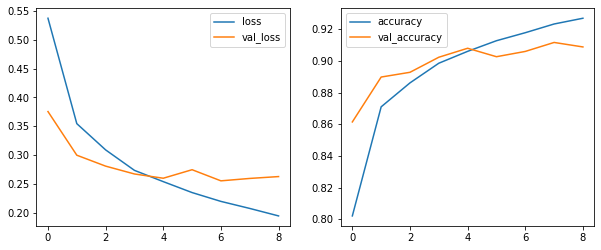

In [30]:
import pandas as pd

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(kind='line', ax=ax[0])
history_df[['accuracy', 'val_accuracy']].plot(kind='line', ax=ax[1]);

## Evaluate Model Performance on Test Data

In [34]:
y_pred = model.predict(test_images)
y_pred = y_pred.argmax(axis=1)
print(classification_report(y_test, y_pred,
      target_names=class_names))

              precision    recall  f1-score   support

 T-shirt/top       0.81      0.89      0.85      1000
     Trouser       0.99      0.98      0.98      1000
    Pullover       0.82      0.89      0.85      1000
       Dress       0.90      0.92      0.91      1000
        Coat       0.86      0.84      0.85      1000
      Sandal       0.98      0.98      0.98      1000
       Shirt       0.76      0.64      0.69      1000
     Sneaker       0.95      0.97      0.96      1000
         Bag       0.98      0.97      0.98      1000
  Ankle boot       0.97      0.96      0.97      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



# Training a CNN with 1-Cycle Learning Rate

In [50]:
def lr_function(epoch):
    start_lr = 1e-4; min_lr = 5e-4; max_lr = 5e-2
    rampup_epochs = 4; sustain_epochs = 0; exp_decay = .8
    
    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, 
           sustain_epochs, exp_decay):
        if epoch < rampup_epochs:
            lr = ((max_lr - start_lr) / rampup_epochs 
                        * epoch + start_lr)
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        else:
            lr = ((max_lr - min_lr) * 
                      exp_decay**(epoch - rampup_epochs -
                                    sustain_epochs) + min_lr)
        return lr

    return lr(epoch, start_lr, min_lr, max_lr, 
              rampup_epochs, sustain_epochs, exp_decay)
    

start lr: 0.0001 
end lr: 0.0005021560290768111


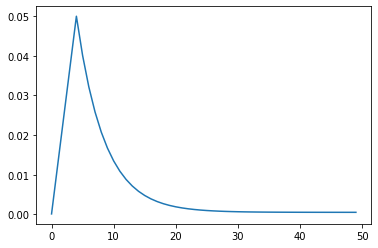

In [51]:
import matplotlib.pyplot as plt

rng = [i for i in range(50)]
y = [lr_function(x) for x in rng]
plt.plot(rng, [lr_function(x) for x in rng])
print('start lr:', y[0], '\nend lr:', y[-1])

In [52]:
# define input shape
INPUT_SHAPE = (28, 28, 1)

# define sequential model
model = tf.keras.models.Sequential()
# define conv-pool layers - set 1
model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), 
                                activation='relu', padding='valid', input_shape=INPUT_SHAPE))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# define conv-pool layers - set 2
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), 
                                activation='relu', padding='valid'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# add flatten layer
model.add(tf.keras.layers.Flatten())

# add dense layers with some dropout
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.3))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.3))

# add output layer
model.add(tf.keras.layers.Dense(10, activation='softmax'))

In [53]:
epochs = 100

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                     patience=2, 
                                     restore_best_weights=True),
    tf.keras.callbacks.LearningRateScheduler(lambda epoch: \
                                             lr_function(epoch), 
                                             verbose=True)
    
]

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)               205056    
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)              

In [54]:
history = model.fit(train_images, y_train,
                    batch_size=32,
                    callbacks=[es_callback], 
                    validation_split=0.1, epochs=EPOCHS,
                    verbose=1)

Epoch 1/100
1688/1688 [==============================] - 5s 3ms/step - loss: 1.2095 - accuracy: 0.5795 - val_loss: 0.5206 - val_accuracy: 0.8035
Epoch 2/100
1688/1688 [==============================] - 4s 3ms/step - loss: 0.5511 - accuracy: 0.7921 - val_loss: 0.4393 - val_accuracy: 0.8412
Epoch 3/100
1688/1688 [==============================] - 4s 2ms/step - loss: 0.4591 - accuracy: 0.8322 - val_loss: 0.3909 - val_accuracy: 0.8545
Epoch 4/100
1688/1688 [==============================] - 4s 3ms/step - loss: 0.4152 - accuracy: 0.8503 - val_loss: 0.3654 - val_accuracy: 0.8675
Epoch 5/100
1688/1688 [==============================] - 4s 2ms/step - loss: 0.3809 - accuracy: 0.8600 - val_loss: 0.3464 - val_accuracy: 0.8717
Epoch 6/100
1688/1688 [==============================] - 4s 3ms/step - loss: 0.3653 - accuracy: 0.8685 - val_loss: 0.3389 - val_accuracy: 0.8750
Epoch 7/100
1688/1688 [==============================] - 4s 2ms/step - loss: 0.3398 - accuracy: 0.8773 - val_loss: 0.3212 - val_ac

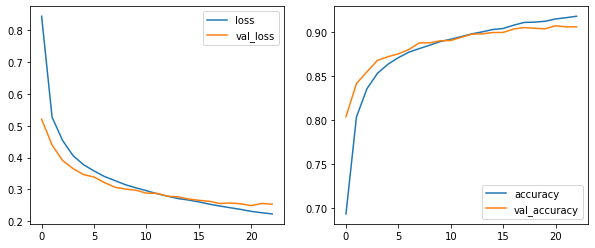

In [55]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(kind='line', ax=ax[0])
history_df[['accuracy', 'val_accuracy']].plot(kind='line', ax=ax[1]);

In [56]:
y_pred = model.predict(test_images)
y_pred = y_pred.argmax(axis=1)
print(classification_report(y_test, y_pred,
      target_names=class_names))

              precision    recall  f1-score   support

 T-shirt/top       0.84      0.86      0.85      1000
     Trouser       0.99      0.98      0.98      1000
    Pullover       0.87      0.86      0.86      1000
       Dress       0.90      0.91      0.91      1000
        Coat       0.84      0.88      0.86      1000
      Sandal       0.98      0.98      0.98      1000
       Shirt       0.75      0.70      0.73      1000
     Sneaker       0.95      0.96      0.96      1000
         Bag       0.97      0.98      0.98      1000
  Ankle boot       0.96      0.96      0.96      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

